# NASA Earthdata Search and Discovery for PACE data
**Author:** Eli Holmes (NOAA)</br>
Last updated: Jan 22, 2026

[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/fish-pace/2025-tutorials/blob/main/pace_earthdata_access.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link] [![JupyterHub](https://img.shields.io/badge/Workshop_Hub-green?style=for-the-badge)][jupyter-link]

[download-link]: https://github.com/fish-pace/2025-tutorials/blob/main/pace_earthdata_access.ipynb
[colab-link]: https://colab.research.google.com/github/fish-pace/2025-tutorials/blob/main/pace_earthdata_access.ipynb
[jupyter-link]: https://workshop.nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/pace_earthdata_access.ipynb

>📘 Learning Objectives
>
> 1. How to authenticate with `earthaccess.login()`
> 2. How to use `earthaccess.search_data()` to search for data using spatial and temporal filters
> 3. How to explore and work with search results
> 4. Use `xarray.open_dataset()` to load Level 3 data
> 6. Use xarray and datatree to load Level 2 data
> 7. (Optional) Plotting and managing memory.


## Summary

In this example we will use the `earthaccess` library to search for data collections from NASA Earthdata. `earthaccess` is a Python library that simplifies data discovery and access to NASA Earth science data by providing an abstraction layer for NASA’s [Common Metadata Repository (CMR) API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html) Search API. The library makes searching for data more approachable by using a simpler notation instead of low level HTTP queries. `earthaccess` takes the trouble out of Earthdata Login **authentication**, makes **search** easier, and provides a stream-line way to download or stream search results into an `xarray` object.

For more on `earthaccess` visit the [`earthaccess` GitHub](https://github.com/nsidc/earthaccess) page and/or the [`earthaccess` documentation](https://earthaccess.readthedocs.io/en/latest/) site. Be aware that `earthaccess` is under active development. 

## Prerequisites

An Earthdata Login account is required to access data from NASA Earthdata. Please visit <https://urs.earthdata.nasa.gov> to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.  


In [1]:
# If running in Colab, uncomment (delete the #) and run this line
# !pip install xarray earthaccess cartopy

### Import Required Packages  

In [2]:
import earthaccess
import xarray as xr

## Authenticate to NASA Earthdata

This will ask for your username and password. `persist=True` will cause a `.netrc` file to be added to your home directory with your Earthdata login information.

In [4]:
auth = earthaccess.login(persist=True)

## Search for data  `earthaccess.search_data()` 

We want to search NASA Earthdata for collections using the OCI instrument. Use
<https://search.earthdata.nasa.gov/search?fi=OCI>

There are multiple keywords we can use to discovery data from collections. We are going to focus on  `short_name` here, but you can also use `concept_id`, and `doi`. 

### Search by sensor `instrument="oci"`

In [5]:
results = earthaccess.search_datasets(instrument="oci")
for item in results[1:20]:
    summary = item.summary()
    print(summary["short-name"])

PACE_OCI_L1A_SCI
PACE_OCI_L1B_SCI
PACE_OCI_L1C_SCI
PACE_OCI_L2_UVAI_UAA_NRT
PACE_OCI_L2_UVAI_UAA
PACE_OCI_L2_AER_UAA_NRT
PACE_OCI_L2_AER_UAA
PACE_OCI_L2_AOP_NRT
PACE_OCI_L2_AOP
PACE_OCI_L2_CLOUD_MASK_NRT
PACE_OCI_L2_CLOUD_MASK
PACE_OCI_L2_CLOUD_NRT
PACE_OCI_L2_CLOUD
PACE_OCI_L2_IOP_NRT
PACE_OCI_L2_IOP
PACE_OCI_L2_LANDVI_NRT
PACE_OCI_L2_LANDVI
PACE_OCI_L2_BGC
PACE_OCI_L2_BGC_NRT


### Search by short name `short_name = ""`

Let's look at Level 2 Apparent Optical Properties. Short name is `PACE_OCI_L2_AOP`. Notice `L2` in the name. I can restrict to a time period using `temporal` with start and end date.


In [4]:
# Level 2 data
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L2_AOP',
    temporal = ("2025-03-05", "2025-03-05")
)
len(results)

143

Why are there so many?? Level 2 data is swath data not a global grid. For swath data (level 2), we need to specify a bounding box so we only get the swath(s) over our region of interest. Here we specify a bounding box for the U.S. Great Lakes. Now we see there are 3 files for that day and box.

In [6]:
# Level 2 data
# bounding_box = (lat_min, lon_min, lat_max, lon_max)
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L2_AOP',
    temporal = ("2025-03-05", "2025-03-05"),
    bounding_box = (-90.0, 40.0, -75.0, 47.0)
)
len(results)

3

The Level 3 mapped data is global data on a grid (no swaths and no tiles) so there should be one file per day, right? Notice the `L3M` in the short_name.

In [7]:
# Level 3 data
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_RRS',
    temporal = ("2025-03-05", "2025-03-05")
)
len(results)

16

Why so many? There are month, 8-day, day and 2 resolutions. Look at the url for `Data:` in the `results` object.

In [7]:
results[0:5]

[Collection: {'Version': '3.1', 'ShortName': 'PACE_OCI_L3M_RRS'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'EastBoundingCoordinate': 180, 'SouthBoundingCoordinate': -90, 'NorthBoundingCoordinate': 90, 'WestBoundingCoordinate': -180}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-12-21T00:00:00Z', 'EndingDateTime': '2025-03-20T23:59:59Z'}}
 Size(MB): 3143.3699989318848
 Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20241221_20250320.L3m.SNWI.RRS.V3_1.Rrs.4km.nc'],
 Collection: {'ShortName': 'PACE_OCI_L3M_RRS', 'Version': '3.1'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'NorthBoundingCoordinate': 90, 'SouthBoundingCoordinate': -90, 'WestBoundingCoordinate': -180, 'EastBoundingCoordinate': 180}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-12-21T00:00:00Z', 'EndingDateTime': '2025-03-20T23:59:59Z'}}
 Size(MB): 579.0568437

In [8]:
# here is a way to just get the urls
[res.data_links() for res in results]

[['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20241221_20250320.L3m.SNWI.RRS.V3_1.Rrs.4km.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20241221_20250320.L3m.SNWI.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250202_20250305.L3m.R32.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250202_20250305.L3m.R32.RRS.V3_1.Rrs.4km.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250210_20250313.L3m.R32.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250210_20250313.L3m.R32.RRS.V3_1.Rrs.4km.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250218_20250321.L3m.R32.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250218_20250321.L

We can filter/select files with a specific name format using `granule_name`.

In [8]:
# Level 3 data filtering on file/granule name
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_RRS',
    temporal = ("2025-03-05", "2025-03-05"),
    granule_name="*.MO.*.0p1deg.*"
)
len(results)

1

### Refining the search

Here are the common arguments for `earthaccess.search_data()`:

* `bounding_box` is a lat/lon box, e.g. `(xmin=-73.5, ymin=33.5, xmax=-43.5, ymax=43.5)`
* `temporal` is a date range, e.g. `("2020-01-16", "2020-12-16")`
* `cloud_cover` is a range `(0, 10)`
* `granule_name` is a matching filter, e.g. `"*.DAY.*.0p1deg.*"`
* `short_name` or `collection_id`

### Summary

* `earthaccess.login()` to authenticate
* `earthaccess.search_data()` to find the data files. This gives an object with all the info needed to get the data.
* `earthaccess.search_data()` returns a dictionary/list with information on the data files.

```
# Level 3 4km global
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_RRS',
    temporal = ("2025-03-05", "2025-03-05"),
    granule_name="*.MO.*.0p1deg.*"
)

# Level 2 1km swath (tiles)
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L2_AOP',
    temporal = ("2025-03-05", "2025-03-05"),
    bounding_box = (-90.0, 40.0, -75.0, 47.0)
)
```


## Load data into memory using `xarray`

Following the search for data, we will **load data** directly into memory using `xarray` functions.

#### What are the granules (files)

In [9]:
# Level 3 data (global)
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_RRS',
    temporal = ("2025-03-01", "2025-03-01"),
    granule_name="*.MO.*.0p1deg.*"
)
len(results)

1

In [10]:
results[0]

Collection: {'Version': '3.1', 'ShortName': 'PACE_OCI_L3M_RRS'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180, 'EastBoundingCoordinate': 180, 'NorthBoundingCoordinate': 90, 'SouthBoundingCoordinate': -90}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2025-03-31T23:59:59Z', 'BeginningDateTime': '2025-03-01T00:00:00Z'}}
Size(MB): 603.157995223999
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250301_20250331.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc']

### Step 1 Set up a file pointer

We use `earthaccess`'s `open()` method to create a 'fileset' to the cloud objects with the info needed to open data in cloud buckets. `earthaccess` does a lot of heavy lifting for us. It identifies the downloadable links, passes our Earthdata Login credentials, and saves the files with the proper names.

In [11]:
fileset = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

### Step 2 Read the file using `xarray.open_dataset()`

We can load the information about the data and look at its properties without actually loading all the data into memory. Here we load one file using `fileset[0]`.

In [13]:
# Open with xarray
import xarray as xr
ds = xr.open_dataset(fileset[0], chunks={})
ds

<xarray.Dataset> Size: 4GB
Dimensions:     (lat: 1800, lon: 3600, wavelength: 172, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 4GB dask.array<chunksize=(16, 1024, 8), meta=np.ndarray>
    palette     (rgb, eightbitcolor) uint8 768B dask.array<chunksize=(3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20250301_20250331.L3m.MO.RRS....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3548336
    data_minimum:                      -0.009993999
    data_maximum:                      0.09678001

We have "lazy" loaded the data, not loaded into memory. This is important since the data are big.

In [14]:
ds_size_gb = ds.nbytes / 1e9
print(f"Dataset size: {ds_size_gb:.2f} GB")

Dataset size: 4.46 GB


### Summary

* `earthaccess.open()` to create an object (fileset or path) for working with data in the cloud.
* `xarray.open_dataset()` to open the file (but not load data into memory yet)

```
# Get results
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_RRS',
    temporal = ("2025-03-05", "2025-03-05"),
    granule_name="*.MO.*.0p1deg.*"
)

# lazy load data
import xarray as xr
fileset = earthaccess.open(results)
ds = xr.open_dataset(fileset[0], chunks={})
ds
```

In some cases you may want to download your assets. Use the `earthaccess.download()` function. 

```
downloaded_files = earthaccess.download(
    results[0:9],
    local_path='data',
)
```

## Example: Level 3 mapped data `L3M`

Level 3 data is on a global lat/lon grid. The short name will have `L3M` in it. The resolution (width/height) of the grids is either 4km or 0.1 degrees. 

Let's load a year of data.

#### Step 1. Search for the data

In [15]:
# Level 3 data (global)
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_RRS',
    temporal = ("2024-03-01", "2025-02-01"),
    granule_name="*.MO.*.0p1deg.*"
)
len(results)

12

In [18]:
# look at the file names to make sure they are ok
[res.data_links() for res in results]

[['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240301_20240331.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240401_20240430.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240501_20240531.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240601_20240630.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240701_20240731.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240801_20240831.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240901_20240930.L3m.MO.RRS.V3_1.Rrs.0p1deg.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20241001_20241031.L

#### Step 2. Set up the fileset

This step is needed so that `xarray` knows how to interact with the data in the cloud bucket.

In [16]:
fileset = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/12 [00:00<?, ?it/s]

#### Step 3. Read one file with xarray

Open one file using `open_dataset()`. Notice the coordinates (lat/lon and wavelength) and the data variables (Rrs).

In [17]:
ds1 = xr.open_dataset(fileset[1])
ds1

<xarray.Dataset> Size: 4GB
Dimensions:     (lat: 1800, lon: 3600, wavelength: 172, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 4GB ...
    palette     (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240401_20240430.L3m.MO.RRS....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3355114
    data_minimum:                      -0.009991998
    data_maximum:                      0.099733464

In [18]:
# here are the wavelengths
ds1['wavelength']

<xarray.DataArray 'wavelength' (wavelength: 172)> Size: 1kB
array([346., 348., 351., 353., 356., 358., 361., 363., 366., 368., 371., 373.,
       375., 378., 380., 383., 385., 388., 390., 393., 395., 398., 400., 403.,
       405., 408., 410., 413., 415., 418., 420., 422., 425., 427., 430., 432.,
       435., 437., 440., 442., 445., 447., 450., 452., 455., 457., 460., 462.,
       465., 467., 470., 472., 475., 477., 480., 482., 485., 487., 490., 492.,
       495., 497., 500., 502., 505., 507., 510., 512., 515., 517., 520., 522.,
       525., 527., 530., 532., 535., 537., 540., 542., 545., 547., 550., 553.,
       555., 558., 560., 563., 565., 568., 570., 573., 575., 578., 580., 583.,
       586., 588., 613., 615., 618., 620., 623., 625., 627., 630., 632., 635.,
       637., 640., 641., 642., 643., 645., 646., 647., 648., 650., 651., 652.,
       653., 655., 656., 657., 658., 660., 661., 662., 663., 665., 666., 667.,
       668., 670., 671., 672., 673., 675., 676., 677., 678., 679., 681., 682.,
       683., 684., 686., 687., 688., 689., 691., 692., 693., 694., 696., 697.,
       698., 699., 701., 702., 703., 704., 706., 707., 708., 709., 711., 712.,
       713., 714., 717., 719.])
Coordinates:
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
Attributes:
    long_name:  wavelengths
    units:      nm
    valid_min:  0
    valid_max:  20000

#### Plot

We can plot this object. But let's not plot the full global data as that is 4+ Gb. We will plot a subset using the `slice()` function. This way we only load the data needed to plot into memory. We need to 
* pick the variable. Let's use `Rrs`
* pick a wavelength using `sel()`
* slice to a smaller lat/lon using `slice()`
* plot

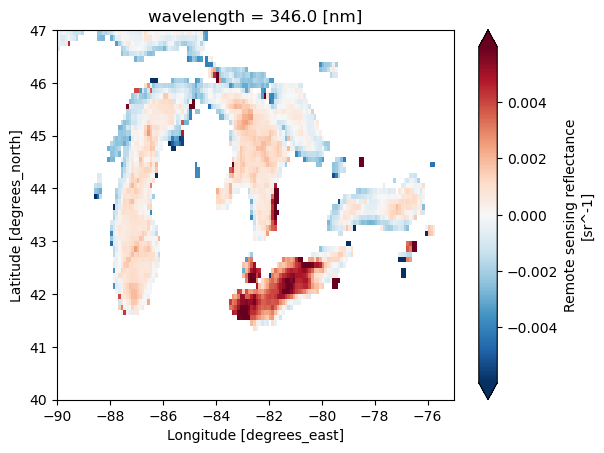

In [19]:
# Plot
rrs = ds1['Rrs']
rrs346 = rrs.sel(wavelength=346)
rrs346_sub = rrs346.sel(lat=slice(47, 40), lon=slice(-90, -75))
rrs346_sub.plot(robust=True);

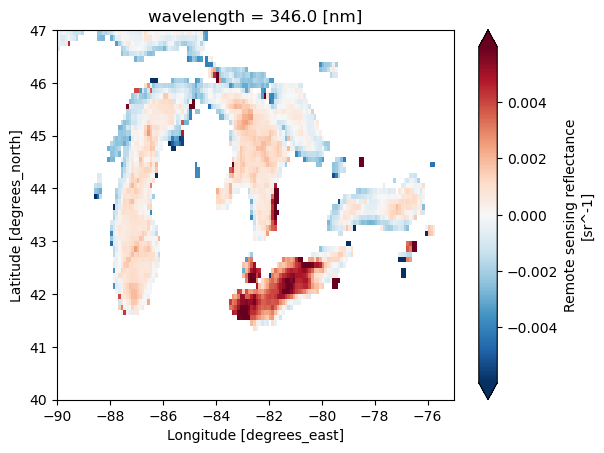

In [24]:
# Note this is how we'd usually write this
rrs = ds1["Rrs"].sel(
    wavelength=346,
    lat=slice(47, 40),
    lon=slice(-90, -75)
)
rrs.plot(robust=True);

### Summary

For Level 3, we use the mapped data product, `L3M` and the steps to open with xarray are
* `earthaccess.search_data()` with `granule_name` to filter to the temporal binning (day, 8-day, month) and resolution (4km or 0.1 degree). We do not need `bounding_box` since level 3 is global.
* `earthaccess.open()` to open the search results
* `ds=xr.open_dataset(fileset[i])` to open the i-th file in the fileset or `ds=xr.open_mfdataset(fileset)` to open multiple datasets.

```
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_RRS',
    temporal = ("2024-03-01", "2025-02-01"),
    granule_name="*.MO.*.0p1deg.*"
)
fileset = earthaccess.open(results)
ds = xr.open_dataset(fileset[1])
```


#### Optional. Open all 12 months and make a plot

Open all 12 files with `open_mfdataset()` and since the netcdf files do not have a time coordinate (just lat, lon, wavelength), we need to tell xarray to combine on a new dimension "time".

In [21]:
# We can open all the files but note there is no time coordinate so we need
# combine="nested" and concat_dim
ds = xr.open_mfdataset(
    fileset,
    combine="nested",
    concat_dim="time")
ds

<xarray.Dataset> Size: 53GB
Dimensions:     (time: 12, lat: 1800, lon: 3600, wavelength: 172, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
Dimensions without coordinates: time, rgb, eightbitcolor
Data variables:
    Rrs         (time, lat, lon, wavelength) float32 53GB dask.array<chunksize=(1, 16, 1024, 8), meta=np.ndarray>
    palette     (time, rgb, eightbitcolor) uint8 9kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240301_20240331.L3m.MO.RRS....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3315440
    data_minimum:                      -0.009997999
    data_maximum:                      0.09494999

In [22]:
# Let's add the time coord since we will likely want to subset on time later
import pandas as pd
t = pd.date_range(start="2024-03-01", end="2025-02-01", freq="MS")
ds = ds.assign_coords(time=t)
ds

<xarray.Dataset> Size: 53GB
Dimensions:     (time: 12, lat: 1800, lon: 3600, wavelength: 172, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * time        (time) datetime64[ns] 96B 2024-03-01 2024-04-01 ... 2025-02-01
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (time, lat, lon, wavelength) float32 53GB dask.array<chunksize=(1, 16, 1024, 8), meta=np.ndarray>
    palette     (time, rgb, eightbitcolor) uint8 9kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240301_20240331.L3m.MO.RRS....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3315440
    data_minimum:                      -0.009997999
    data_maximum:                      0.09494999

Let's plot all the months and fix the warping of space by adding a lat/lon projection, aka tell the plotting that this is lat/lon on a globe.

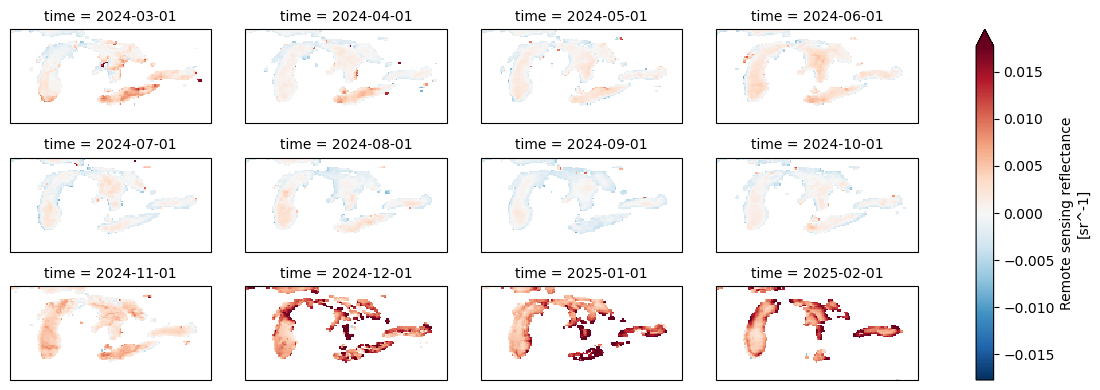

In [23]:
rrs = ds["Rrs"].sel(
    wavelength=346,
    lat=slice(47, 40),
    lon=slice(-90, -75)
)

import cartopy.crs as ccrs
rrs.plot(
    col="time",            # one panel per month
    col_wrap=4,            # 4 columns per row
    robust=True,           # ignore outliers for color scale
    figsize=(12, 4),
    subplot_kws={"projection": ccrs.PlateCarree()},
    transform=ccrs.PlateCarree()
)

## Level 2 data

Level 2 data is not on a global lat/lon grid. Instead each swath (satelite path) has "lines" along the path and "pixels" across the lines (perpendicular to path).  In addition, the data files are GROUPED netcdfs (different format). We need to open these with `open_datatree` and then merge all the groups. 

![image.png](https://images.littlebits.net/uploads/uploaded_image/asset/3830/80cd4fa7-6ccd-485f-a8c4-e1897f0c37ab.png?h=500)

Let's get the swath(s) over the U.S. Great Lakes on March 5th, 2025.

In [25]:
import xarray as xr
import earthaccess
auth = earthaccess.login(persist=True)
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L2_AOP',
    temporal = ("2025-03-05", "2025-03-05"),
    bounding_box = (-90.0, 40.0, -75.0, 47.0)
)
len(results) # one of this is a monthly average

3

In [26]:
# Step 1 set up the fileset
fileset = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
# Step 2 open L2 swath files with xarray open_datatree
datatree = xr.open_datatree(fileset[1], decode_timedelta=False) 
datatree.groups

('/',
 '/sensor_band_parameters',
 '/scan_line_attributes',
 '/geophysical_data',
 '/navigation_data',
 '/processing_control',
 '/processing_control/input_parameters',
 '/processing_control/flag_percentages')

The geophysical data is the data like Rrs and the navigation data has the lat/lon information for each line/pixel.

In [30]:
# Step 3 merge the groups all together.
# This works due to the values in each group being the same shape.
ds_l2 = xr.merge(datatree.to_dict().values())
ds_l2 = ds_l2.set_coords(("longitude", "latitude"))
ds_l2

<xarray.Dataset> Size: 3GB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 172, number_of_lines: 1710,
                    pixels_per_line: 1272)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 1kB 346.0 348.0 351.0 ... 717.0 719.0
    longitude      (number_of_lines, pixels_per_line) float32 9MB ...
    latitude       (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/30)
    wavelength     (number_of_bands) float64 2kB ...
    vcal_gain      (number_of_reflective_bands) float32 1kB ...
    vcal_offset    (number_of_reflective_bands) float32 1kB ...
    F0             (number_of_reflective_bands) float32 1kB ...
    aw             (number_of_reflective_bands) float32 1kB ...
    bbw            (number_of_reflective_bands) float32 1kB ...
    ...             ...
    aot_865        (number_of_lines, pixels_per_line) float32 9MB ...
    angstrom       (number_of_lines, pixels_per_line) float32 9MB ...
    avw            (number_of_lines, pixels_per_line) float32 9MB ...
    nflh           (number_of_lines, pixels_per_line) float32 9MB ...
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB ...
    tilt           (number_of_lines) float32 7kB ...
Attributes: (12/47)
    title:                             OCI Level-2 Data AOP
    product_name:                      PACE_OCI.20250305T174755.L2.OC_AOP.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data3/sdpsoper/vdc/vpu22/wo...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                -102.731316
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     1.0163003206253052
    geospatial_bounds:                 POLYGON ((-63.58643 55.76101, -102.731...

Let's plot. Hmm it's mainly blank. This is daily swath data. There were lots of clouds that day or the swath only included part of region.
* Specify the variable `Rrs` in `[ ]`
* Specify the wavelength, a coordinate, using `.sel()`
* Plot and tell it to use longitude for x and latitude for y.

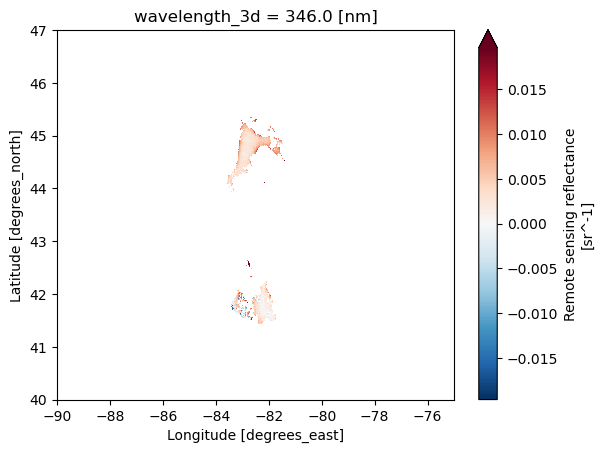

In [31]:
# Plot
rrs = ds_l2['Rrs'].sel(
    wavelength_3d=346)
rrs.plot(robust=True, 
         x="longitude", y="latitude",
         xlim=(-90, -75), ylim=(40, 47));

### Optional. Plot with the outline of the Great Lakes

NameError: name 'ds_l2' is not defined

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


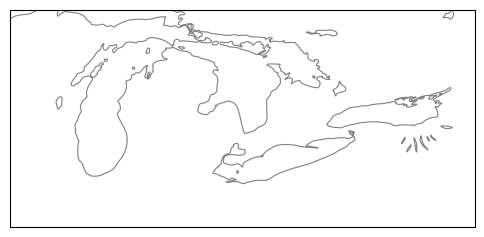

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(6,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-90, -75, 40, 47], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAKES.with_scale("50m"),
               facecolor="none", edgecolor="grey", linewidth=0.8)

# swath pieces
da  = ds_l2["Rrs"].sel(wavelength_3d=346)     # (lines, pixels)
lat = ds_l2["latitude"]
lon = ds_l2["longitude"]

# add to your existing ax (before plt.show)
im = ax.pcolormesh(
    lon, lat, da,
    transform=ccrs.PlateCarree(),
    shading="nearest",      # lighter than 'auto'
    rasterized=True
)
plt.colorbar(im, ax=ax, label="Rrs")

plt.show()



### Summary

With level 2 data, we need to use `xarray.open_datatree()` and then do a `merge` step to get all the variables in the groups. Note we can only work with one level 2 dataset at a time.
* `res=earthaccess.search_data()` with `bounding_box` to filter to the region of interest.
* `fileset=earthaccess.open(res)`
* `datatree=xarray.open_datatree(fileset[i])` to open the i-th file in the fileset.
* `ds=xarray.merge(datatree.to_dict().values())` to merge all the groups
* `ds = ds.set_coords(("longitude", "latitude"))` to make longitude and latitude coords (will help with plotting.

```
# Get L2 data
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L2_AOP',
    temporal = ("2025-03-05", "2025-03-05"),
    bounding_box = (-90.0, 40.0, -75.0, 47.0)
)
fileset = earthaccess.open(results)

# Open with the grouped netCDFs with open_datatree
datatree = xr.open_datatree(fileset[1], decode_timedelta=False)
ds_l2 = xr.merge(datatree.to_dict().values())
ds_l2 = ds_l2.set_coords(("longitude", "latitude"))
ds_l2
```

## Working with larger than memory data

Here are a few basics to know when working with larger-than memory data.

### Chunks

The PACE data are cloud-optimized (read optimized) so that we don't have to read the whole file into memory to work with it and we don't have to download the whole thing if we don't need to.

In [1]:
import earthaccess
import xarray as xr
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_RRS',
    temporal = ("2024-03-01", "2025-04-01"),
    granule_name="*.MO.*.0p1deg.*"
)
fileset = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/14 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/14 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/14 [00:00<?, ?it/s]

In [2]:
# this creates a chunked reference to our data that we can load chunk by chunk
ds_chunk = xr.open_dataset(fileset[0], chunks={})
# this creates a reference that we have to load in its entirety
ds = xr.open_dataset(fileset[0])

In [3]:
ds_size_gb = ds.nbytes / 1e9
print(f"Dataset size: {ds_size_gb:.2f} GB")

Dataset size: 4.46 GB


In [5]:
# Check that ds_chunk is chunked
ds_chunk.chunks

Frozen({'lat': (16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8), 'lon': (1024, 1024, 1024, 528), 'wavelength': (8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4), 'rgb': (3,), 'eightbitcolor': (256,)})

In [6]:
# but ds is not chunked
ds.chunks

Frozen({})

### Chunking allows operations on bigger than memory datasets

Chunking let's us work with big datasets without blowing up our memory. This task takes awhile but it doesn't blow up our little 2Gb RAM virtual machines. `xarray` and `dask` are smart and work through the task chunk by chunk. **Downside is that the chunked dataset is chunked into little chunks which mean a lot of queries to the cloud data to read each little chunk. That means it will be very slow.**

In [13]:
%%time
# ds is not chunked
# This loads a 200 Mb array at once. Watch below how the memory increases (if on a JupyterHub)
var = ds["Rrs"].isel(wavelength=slice(1,9))
global_mean = var.mean().values

CPU times: user 15.3 s, sys: 7.04 s, total: 22.4 s
Wall time: 1min 13s


In [7]:
%%time
# ds_chunk is chunked into little chunks
# This can be done chunk by chunk and will increase the memory usage much since chunks are tiny, but slow.
var = ds_chunk["Rrs"].isel(wavelength=slice(1,9))
global_mean = var.mean().values

CPU times: user 7.2 s, sys: 1.19 s, total: 8.39 s
Wall time: 2min 21s


### Working with Larger-Than-Memory Data When You Cannot Change Chunk Sizes

In the case of the PACE data, the chunk sizes are small and computations are much slower than if we could load all the data into memory **but** we don't blow up the memory so we can work with big files on machines with minimal RAM or with lots of little dask workers in a big RAM machine.

When datasets are stored in the cloud with very small physical chunks, the key is to design computations that minimize repeated remote reads and avoid loading the full array into RAM. Even though the tiny chunking slows down global operations, Dask + Xarray can still handle larger-than-memory workflows efficiently if you structure your analysis around streaming, subsetting, and locality or we can use a non-chunked dataset if we only load in smaller than memory subsets.

#### Practical Tips

* Always subset to your region and time of interest before working with your dataset. So `sel()` and `isel()` before `mean()` or `var()`. Focus only on the wavelengths and variables of interest (so use like `ds["Rrs"]` to get just that variable).
* Avoid operations that require full materialization such as `.load()` or `.values` on large arrays. Instead, keep arrays lazy and call `.compute()` only on reduced results (e.g., monthly means, statistics, anomalies), which keeps memory usage bounded.
* Use `xarray.open_data(..., chunks={})` to create a version of your data that has the chunk references if you need to make sure memory use is limited. This is going to be slower, but won't blow up memory. Use `ds.chunks()` on your xarray dataset to find out if the dataset is chunked or not.
* `.plot()` will load all the data so make sure to plot smaller regions. `hvplot()` uses dask if you want to plot something that is larger than memory.
* Coding LLMs (Claude, ChatGPT) are very helpful in debugging memory issues and chunking issues.
* If you need to run computations with dask, use a machine with big memory and lots of workers because your chunks are small and each worker doesn't need too much memory. But you will likely be limited by the number of http connections you can make (since the bottleneck in cloud data is often the I/O calls).

## Summary

This concludes the `earthaccess` tutorial for PACE data. 
* Opening Level 3 netcdfs with xarray
* Opening Level 2 netcdfs with xarray and datatree
* Working with larger than memory data.
